In [1]:
# In the following I want to preprocess and cluster a Covid 19 dataset. 
# My name is Nicolas Anderson and I do the project at the Helmholtz 
# Institute in Munich.
# I am being supervised by Dr. Carlos Talavera-Lopez. 
# I have a mathematical background.
# Date. 25/09/2022

In [2]:
import numpy as np          
import pandas as pd
import scanpy as sc               #import Scanpy
import os

In [3]:
os.getcwd()    #current work directory

'C:\\Users\\louis.anderson'

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [5]:
results_file = 'write/meyernikolic.h5ad'  # this file stores our analysis results

In [6]:
adata2 = sc.read_h5ad("meyernikolic.h5ad")  # read out our object

In [7]:
adata2            # our AnnData object

AnnData object with n_obs × n_vars = 422220 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'

normalizing counts per cell
    finished (0:00:31)


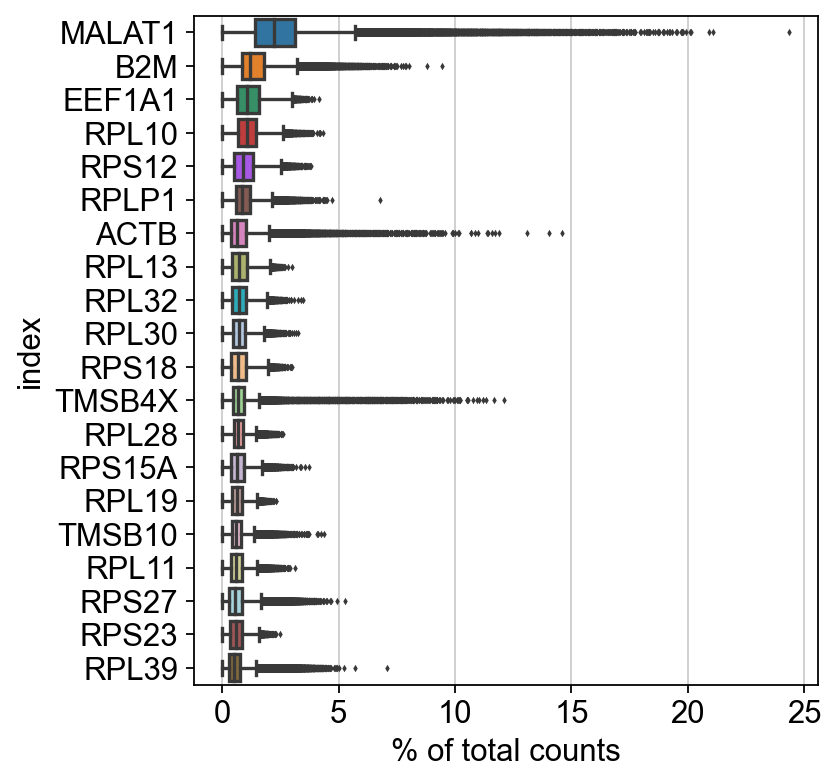

In [8]:
sc.pl.highest_expr_genes(adata2, n_top=20, )
# genes with highest amount of counts per cells
# throughout all cells 

In [9]:
sc.pp.filter_cells(adata2, min_genes=100)  #filter out genes that are detected 
sc.pp.filter_genes(adata2, min_cells=10)   # in less than 10 celles 

filtered out 11348 genes that are detected in less than 10 cells


In [10]:
adata2.var['mt'] = adata2.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

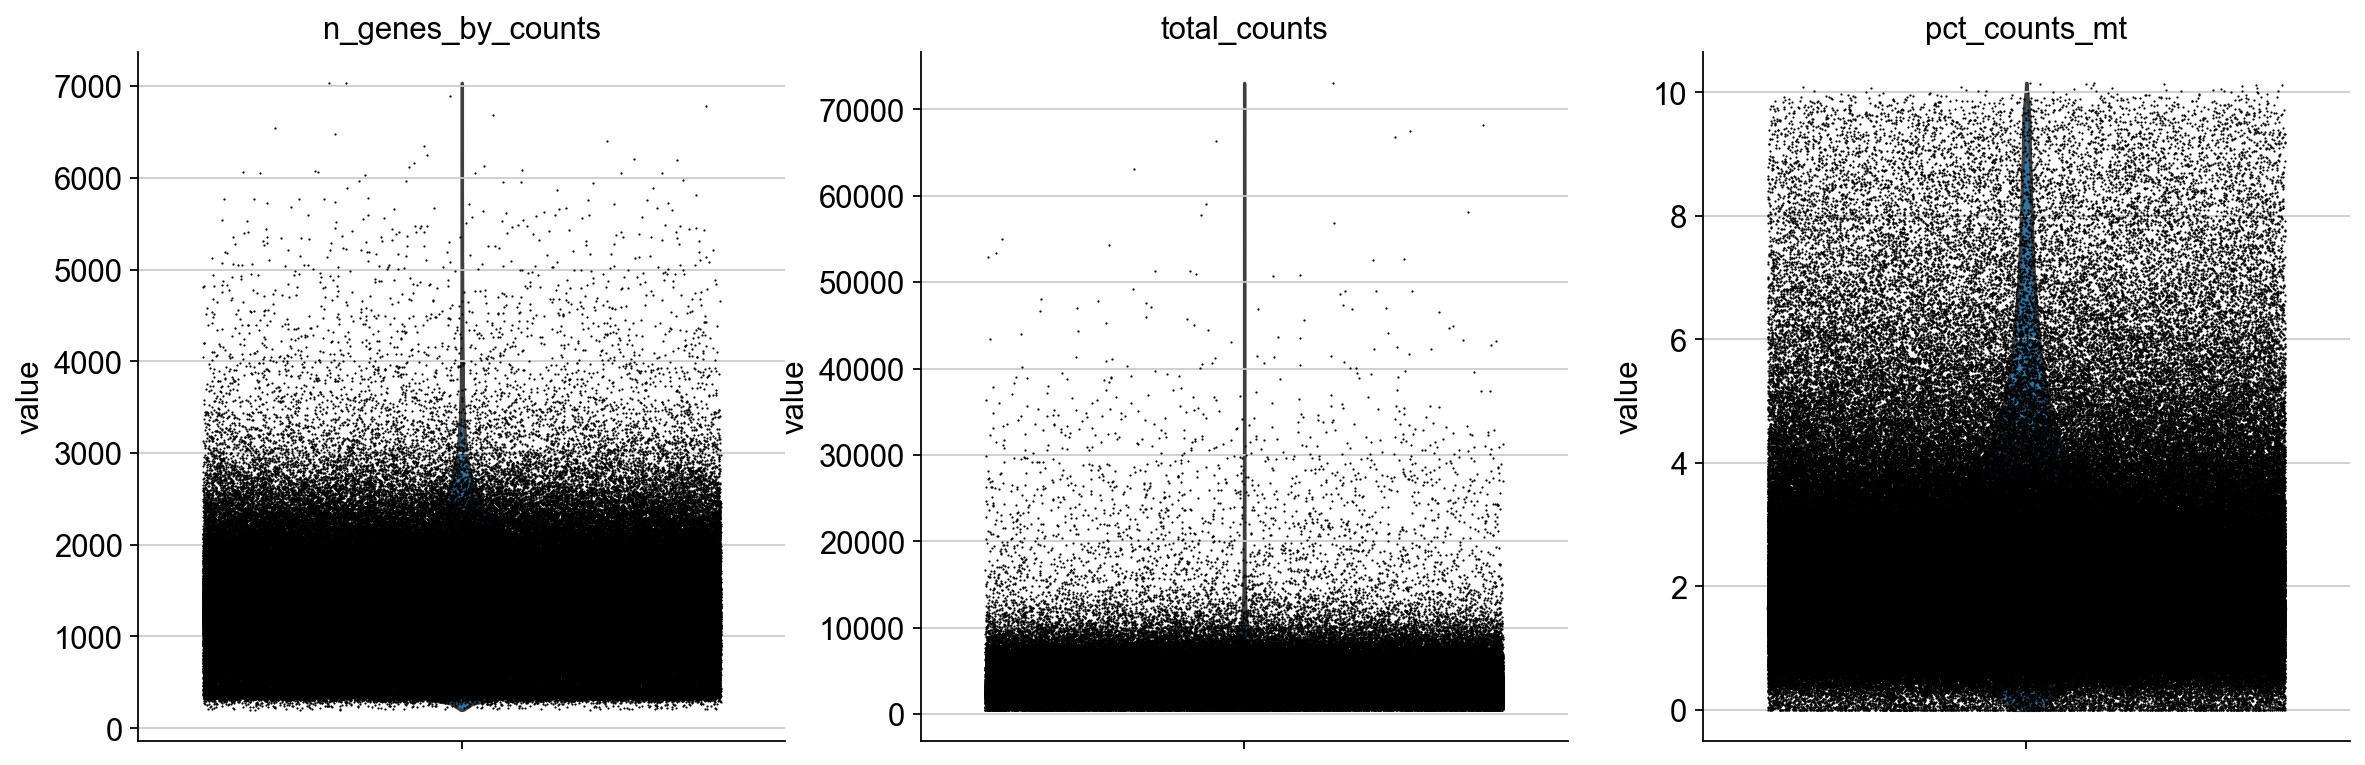

In [11]:
sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
#number of genes expressed in the count matrix
#total counts per cell
#percentage of counts in mitochondrial genes

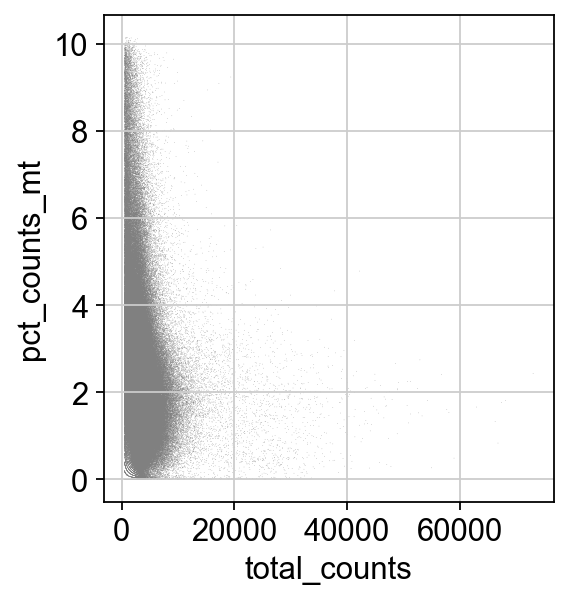

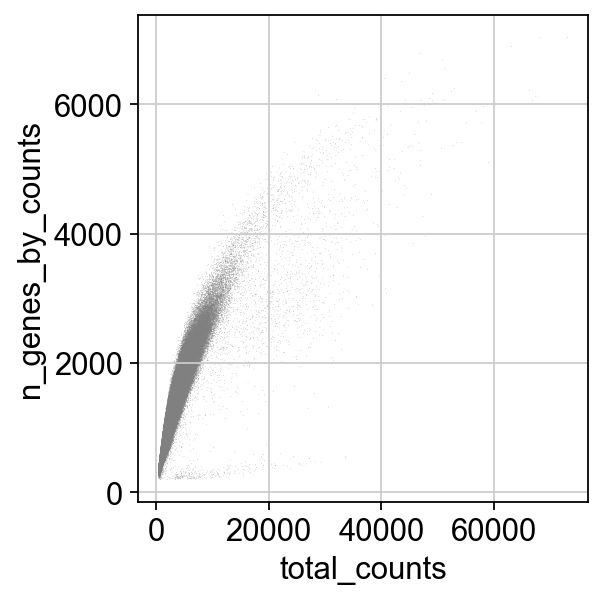

In [12]:
#Remove cells that have...

#too many mitochondrial genes expressed:
sc.pl.scatter(adata2, x='total_counts', y='pct_counts_mt') 


#and too many total counts
sc.pl.scatter(adata2, x='total_counts', y='n_genes_by_counts')

#Mitochondrial genes have a bad impact on the quality of cells.

In [13]:
adata2 = adata2[adata2.obs.n_genes_by_counts < 2500, :]
adata2 = adata2[adata2.obs.pct_counts_mt < 5, :]
#filtering by slicing the AnnData object

In [14]:
sc.pp.normalize_total(adata2, target_sum=1e4)
#we want counts to be comparable among cells. 
#therefore we total-count normalize (library-size correct) the data matrix X 
#to 10,000 reads per cell

C:\Users\louis.anderson\Maxiconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:11)


In [15]:
sc.pp.log1p(adata2)
#logarithmize data in order to display it in a compact way

In [16]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
#we want to identify highly-variable genes

extracting highly variable genes
    finished (0:00:14)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


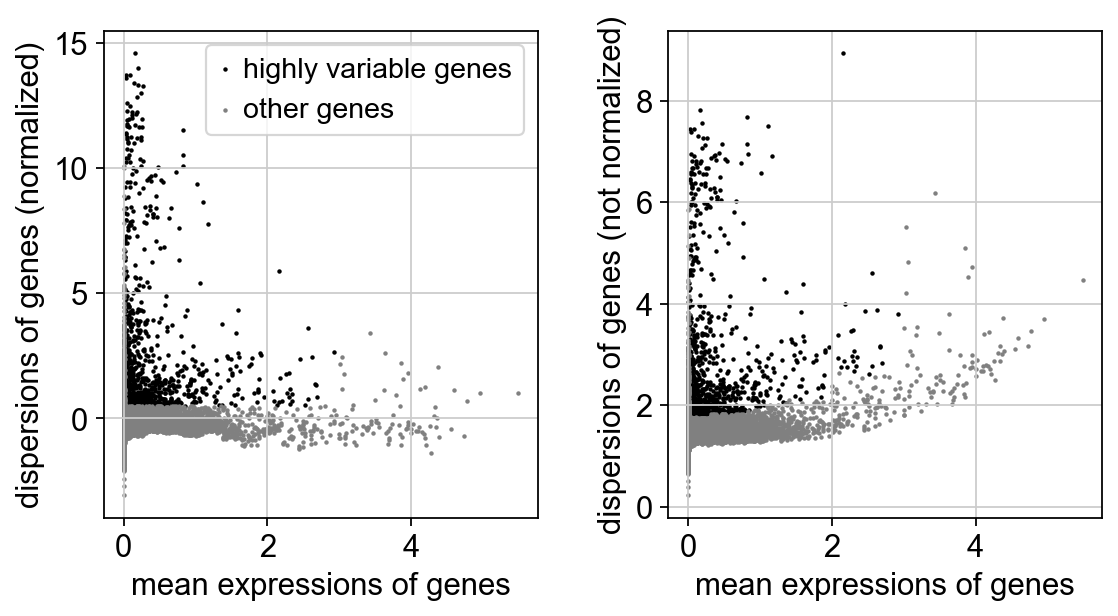

In [17]:
sc.pl.highly_variable_genes(adata2)

In [19]:
#how to get back an AnnData of the object in .raw 
#by calling .raw.to_adata().
adata2.raw = adata2


In [20]:
adata2 = adata2[:, adata2.var.highly_variable]  
#filtering
#not necessary if using .raw

In [21]:
sc.pp.regress_out(adata2, ['total_counts', 'pct_counts_mt'])
#regressing out: 
#effects of total counts per cell 
#and percentage of mitochondrial genes that are expressed 
#then scale the data to unit variance

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:08:29)


In [22]:
sc.pp.scale(adata2, max_value=10)
#scale each gene to unit variance
#filter out values with deviation above 10

In [23]:
sc.tl.pca(adata2, svd_solver='arpack')
 #run principal component analysis (PCA) 
 #in order to reduce then dimensionality of the data
 #PCA reveals the main axes of variation and denoises the data

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:05)


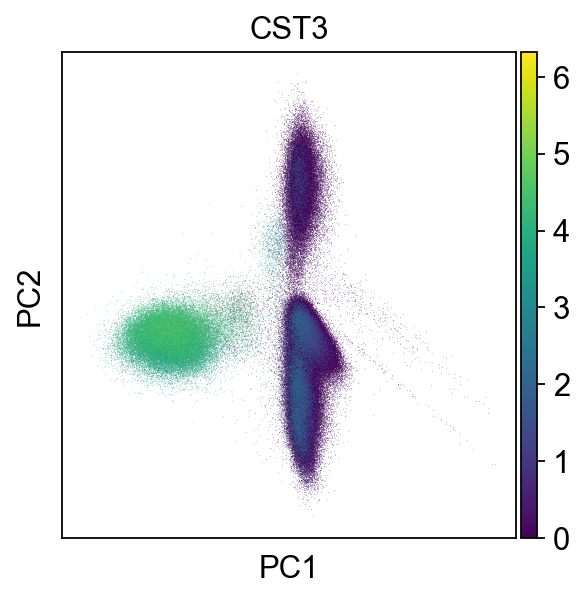

In [24]:
sc.pl.pca(adata2, color='CST3')   #plot


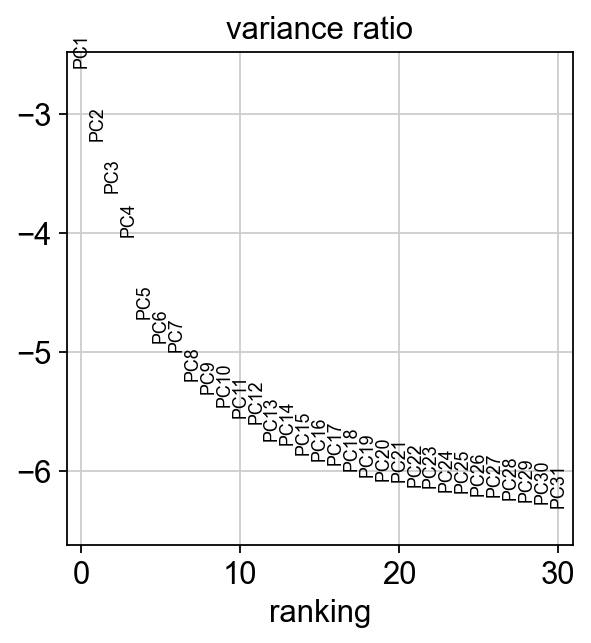

In [25]:
sc.pl.pca_variance_ratio(adata2, log=True)
#ranking of principal components (PCs)
#amount of PCs we should consider 
#aim: compute neighborhood relations of cells

In [26]:
results_file

'write/meyernikolic.h5ad'

In [27]:
adata2.write(results_file)     #save result

In [28]:
adata2       #our "new" AnnData object 
             #after running PCA

AnnData object with n_obs × n_vars = 384606 × 970
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:24)


In [30]:
sc.tl.umap(adata2)
#UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
#We use UMAP for embedding the graph in two dimensions


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:10:12)


KeyError: 'NKG7'

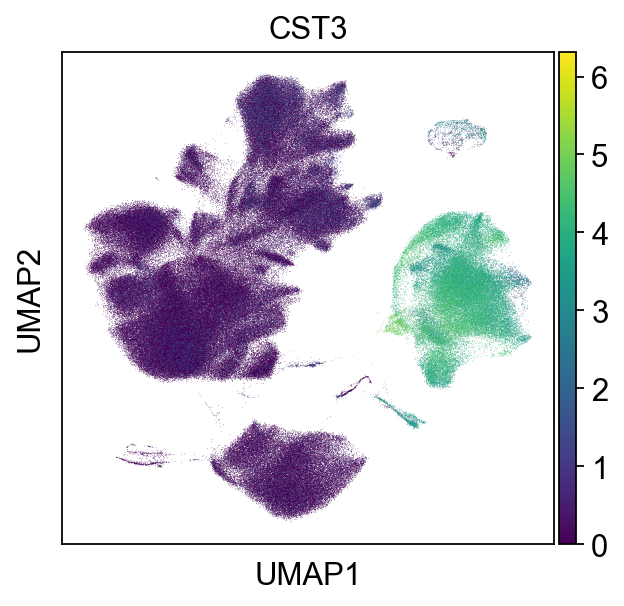

In [35]:
sc.pl.umap(adata2, color=['CST3', 'NKG7', 'PPBP'])

KeyError: 'Could not find key NKG7 in .var_names or .obs.columns.'

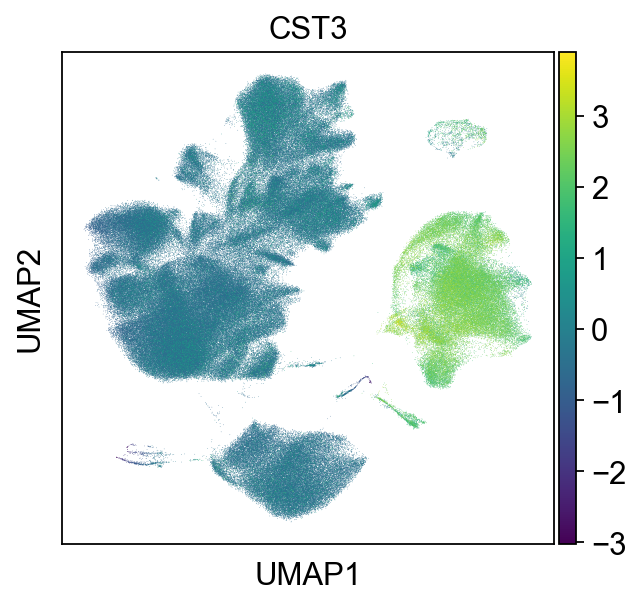

In [36]:
sc.pl.umap(adata2, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [38]:
sc.tl.leiden(adata2)
#use Leiden graph-clustering method for clustering the neighbourhood graph

running Leiden clustering
    finished: found 31 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:09:40)


KeyError: 'NKG7'

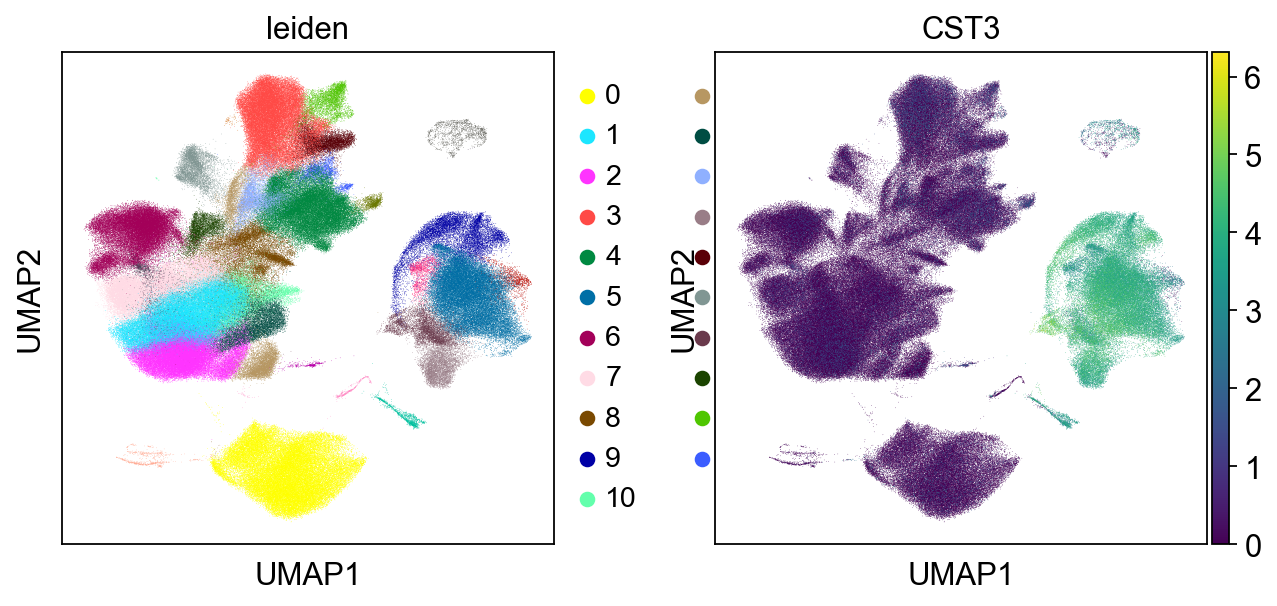

In [39]:
sc.pl.umap(adata2, color=['leiden', 'CST3', 'NKG7'])
#plot clusters

In [40]:
adata2.write(results_file)
#save result

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


C:\Users\louis.anderson\Maxiconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\louis.anderson\Maxiconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\louis.anderson\Maxiconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly 

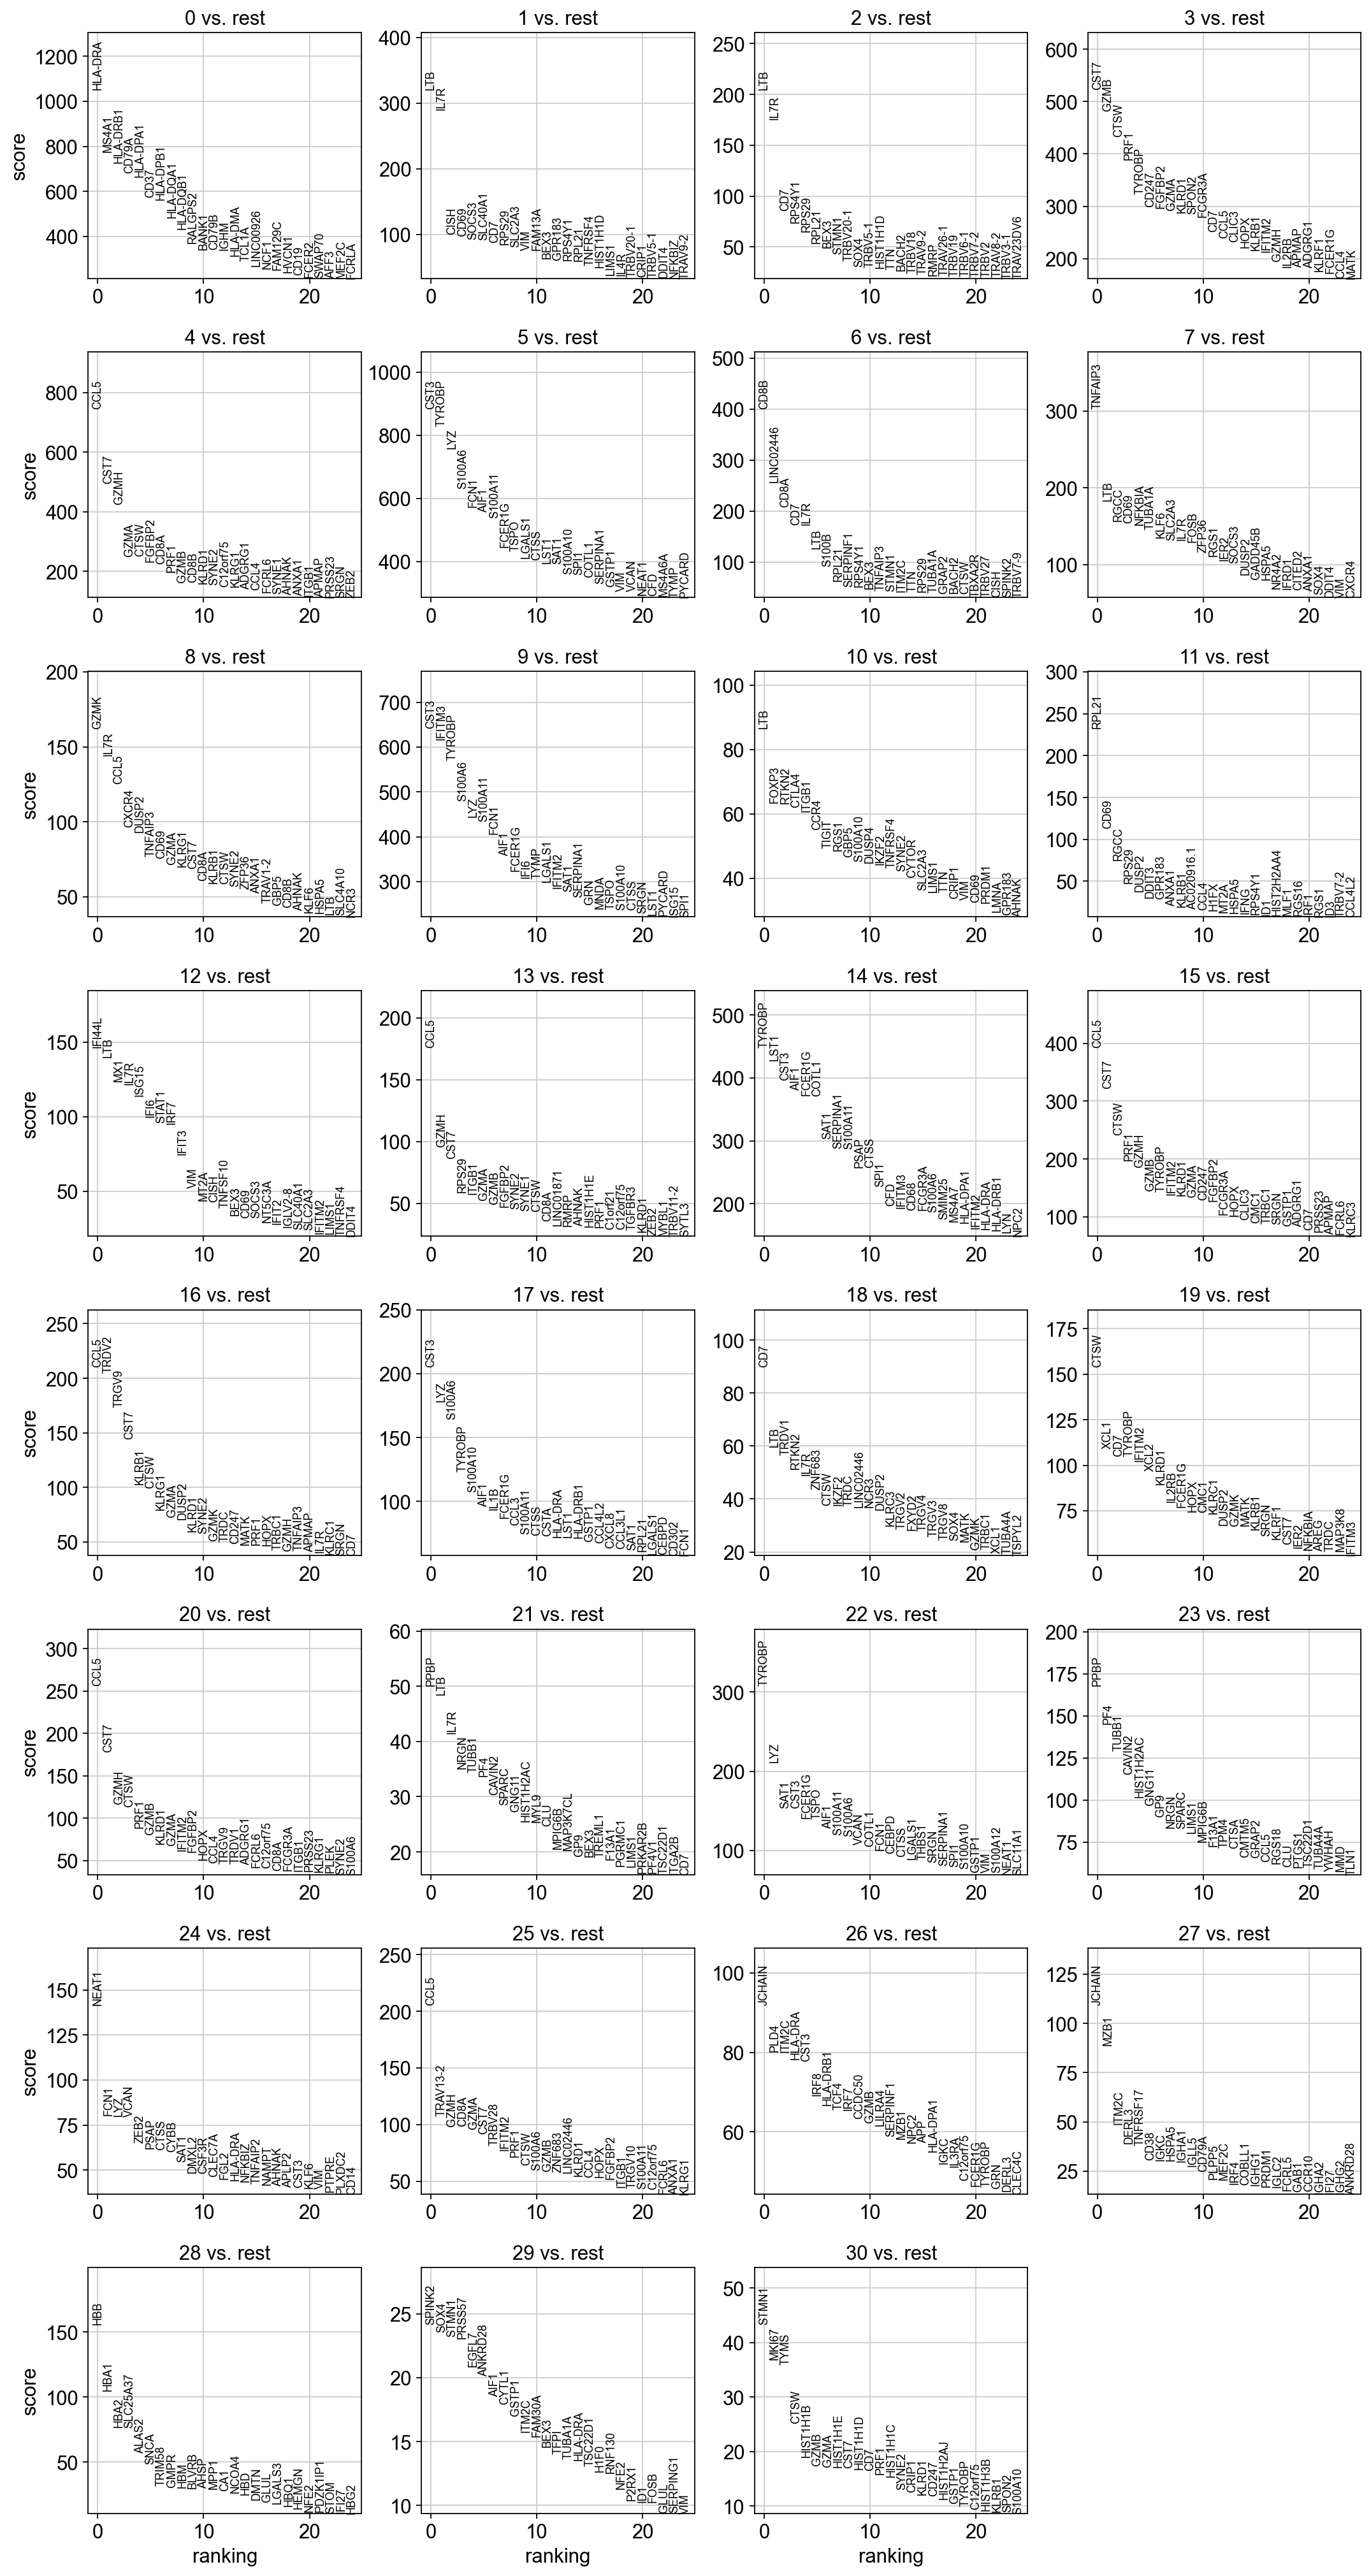

In [41]:
sc.tl.rank_genes_groups(adata2, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)
#t-test
#our aim is to find marker genes
#therefore: compute ranking for the highly differential genes 
#in each cluster
#univariate

In [42]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:01:08)


C:\Users\louis.anderson\Maxiconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\louis.anderson\Maxiconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\louis.anderson\Maxiconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly 

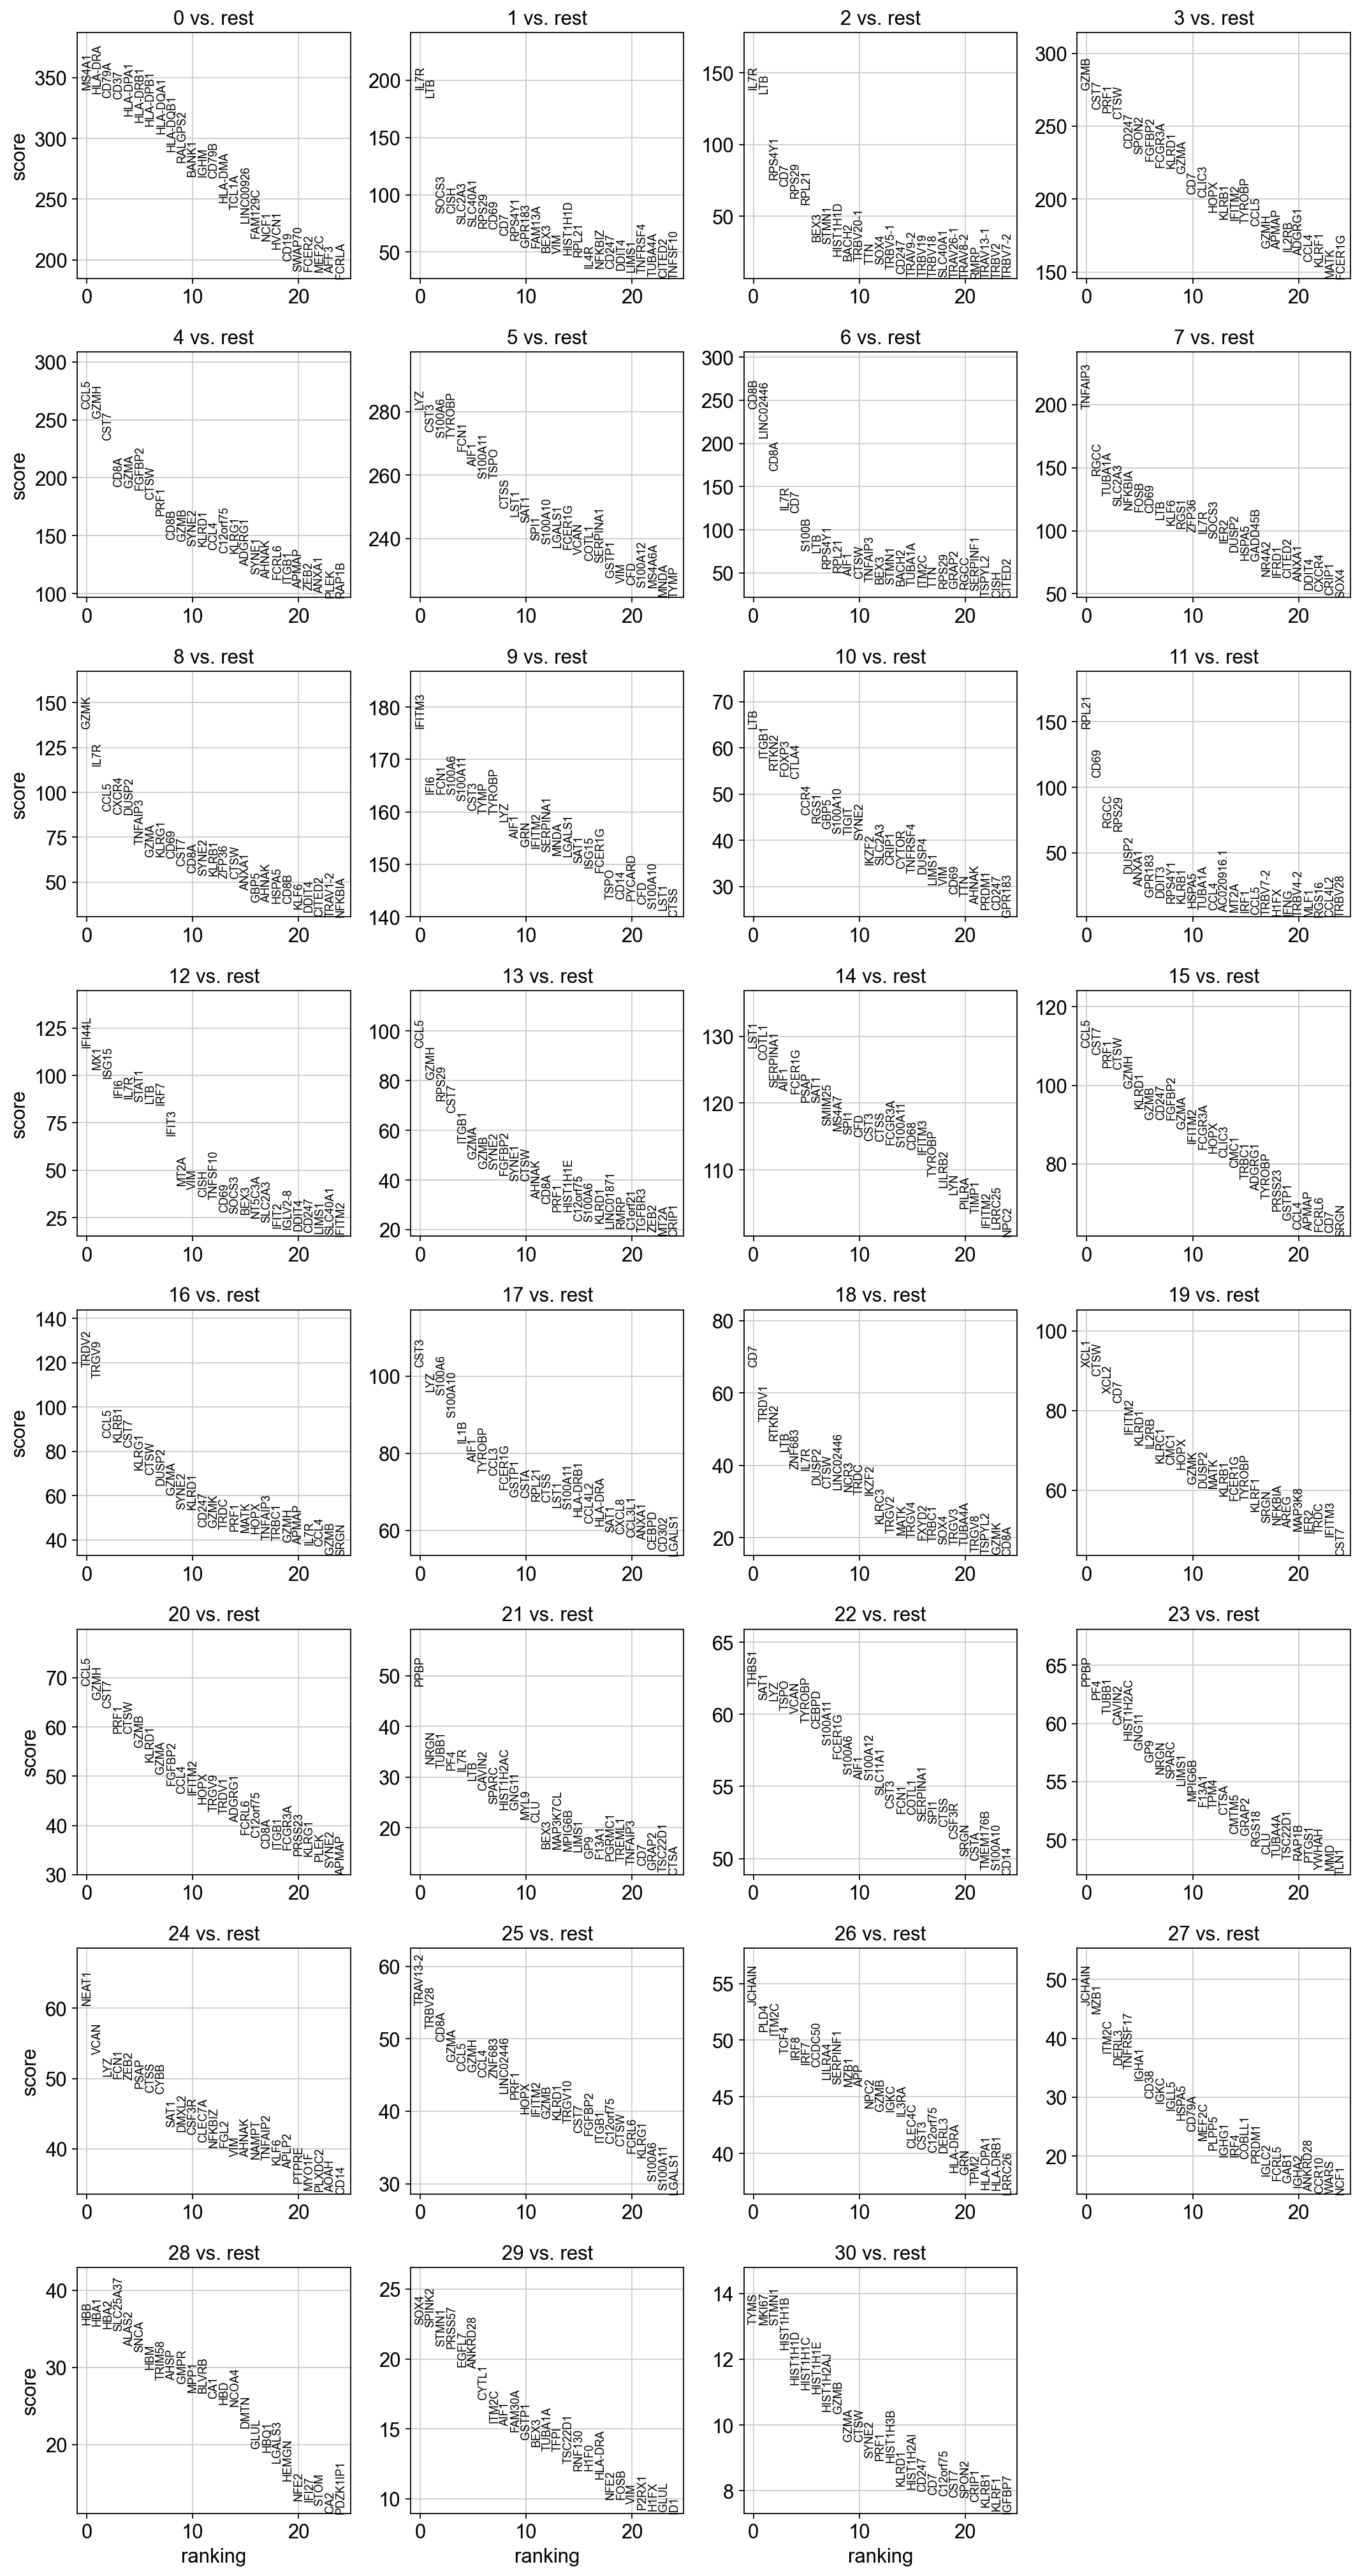

In [43]:
sc.tl.rank_genes_groups(adata2, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)
# use Wilcoxon rank-sum test instead of t-test
# results are obviously similar
# univariate

In [44]:
adata2.write(results_file)   #save result

ranking genes
    finished (0:02:13)


C:\Users\louis.anderson\Maxiconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


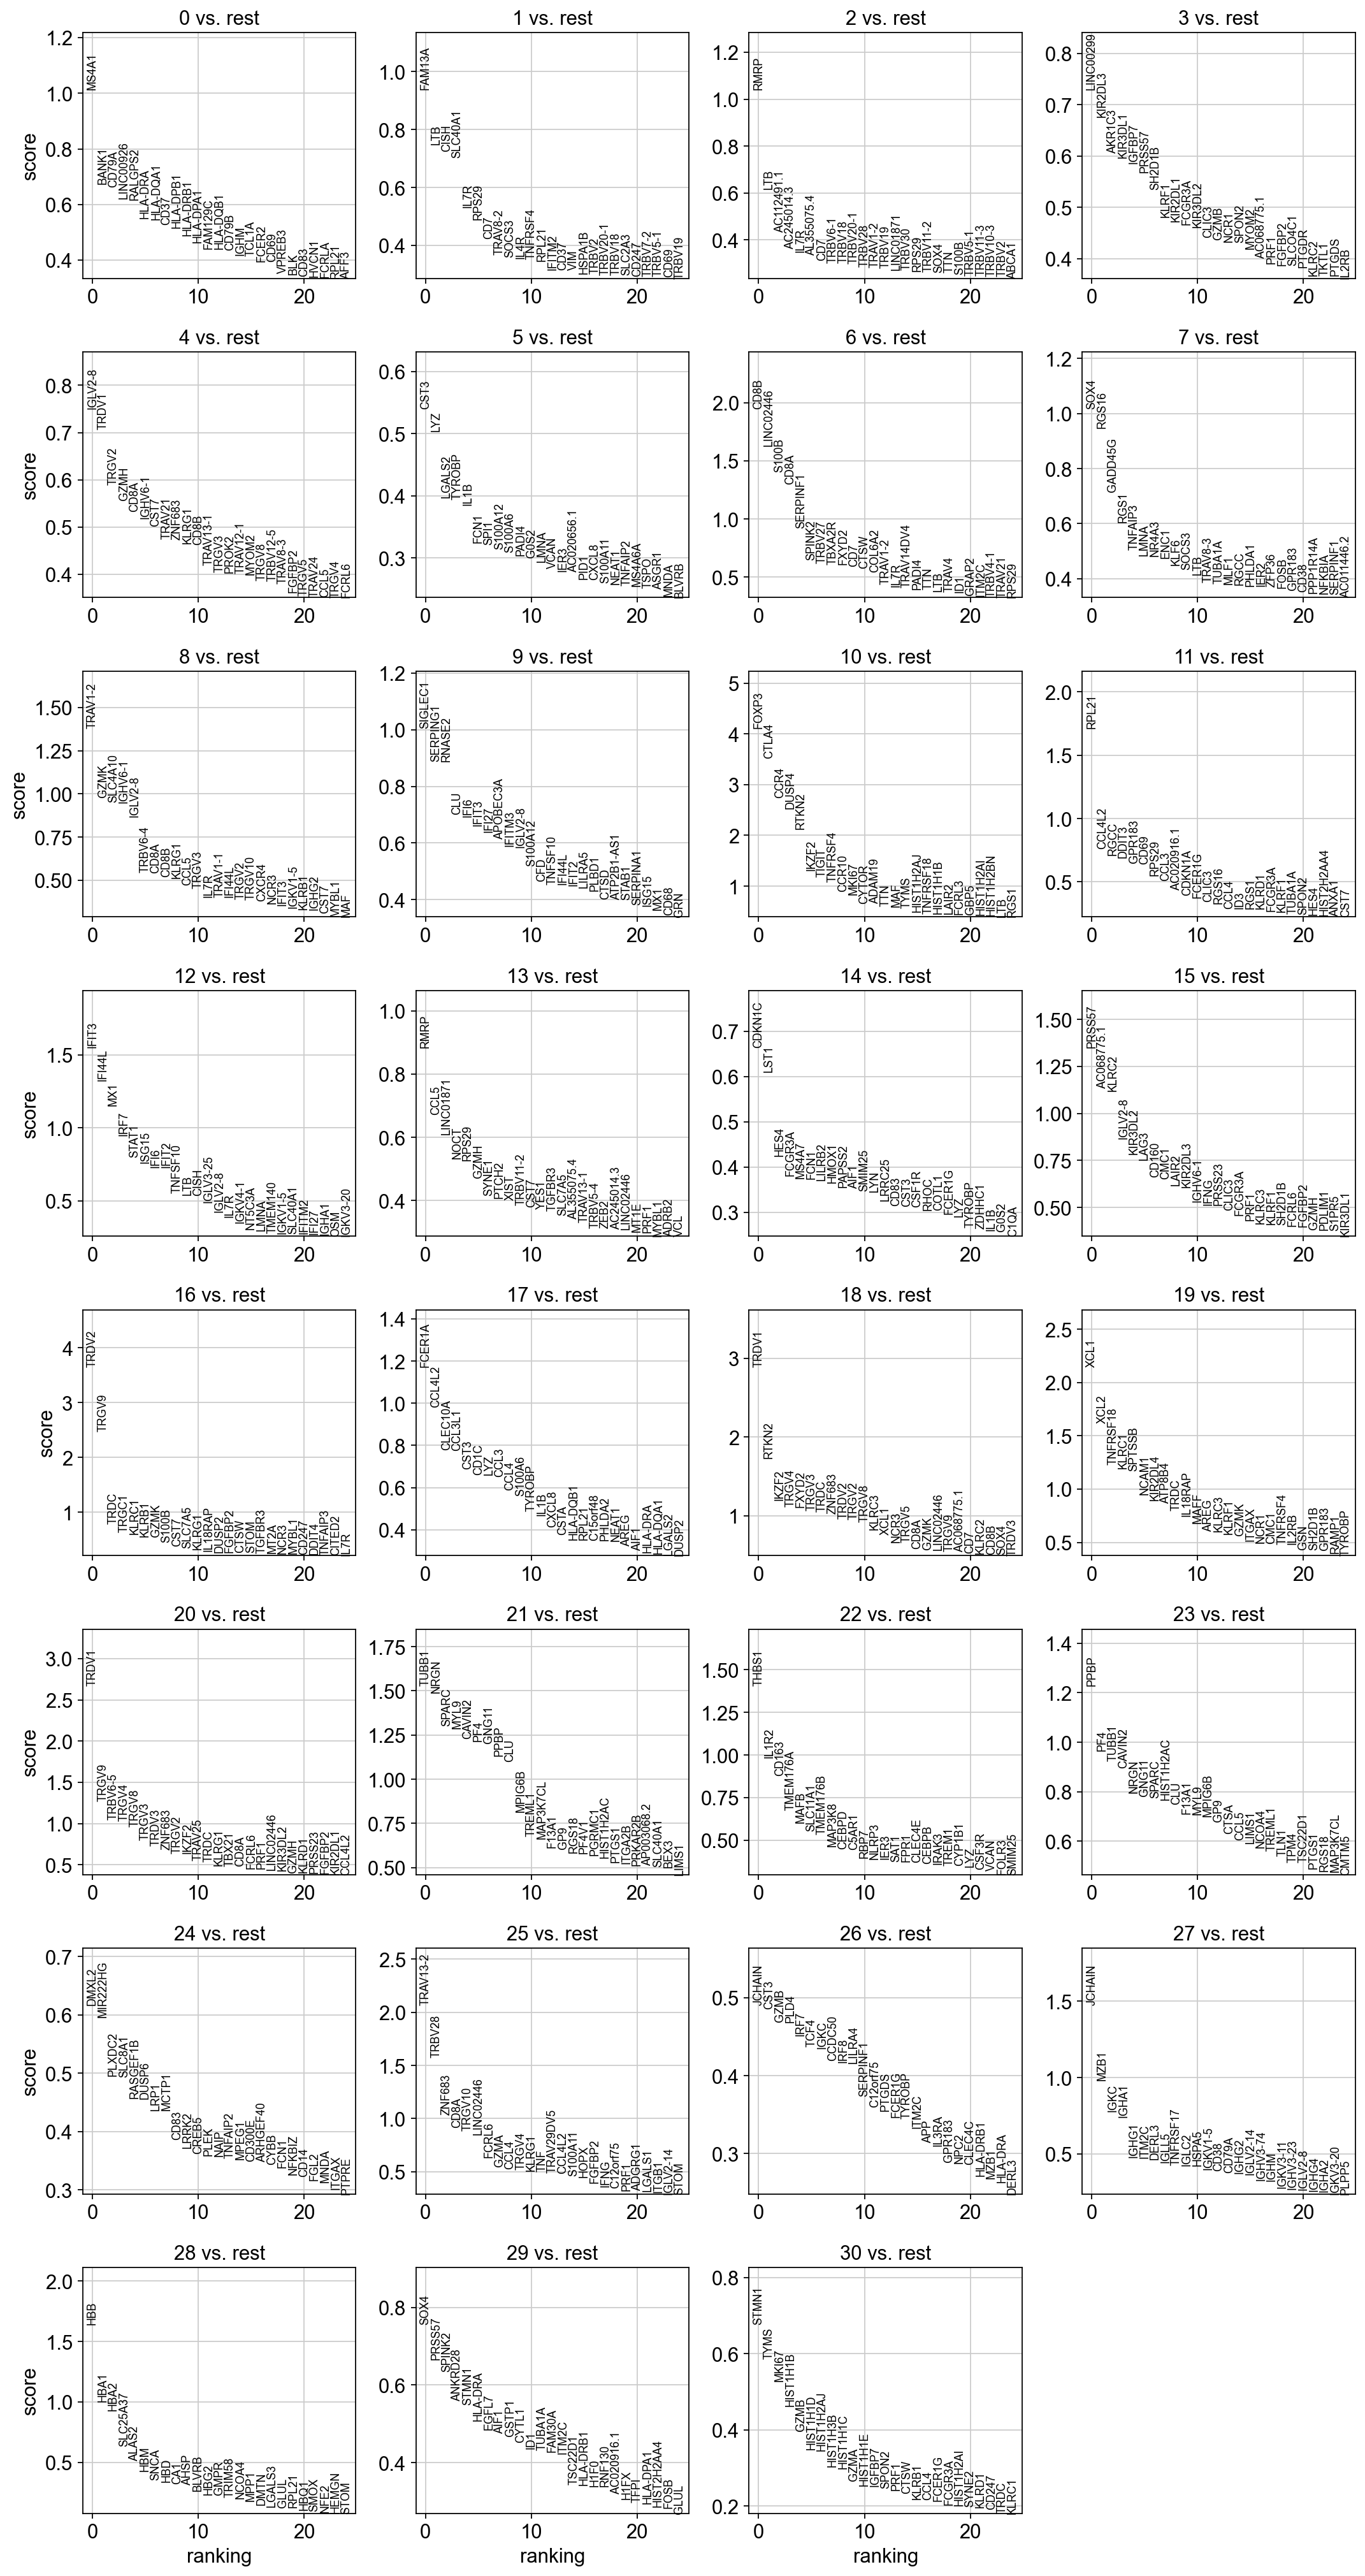

In [45]:
sc.tl.rank_genes_groups(adata2, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)
# finding marker genes/ranking genes 
# by using logistic regression
# multivariate
# however we de not save this result
# we had previously saved the result from the Wilcoxon test
# thus we proceed with the result from the Wilcoxon test
# the Wilcoxon test is deemed to be better suited for publications
# (Sonison and Robinson, 2018)

In [46]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
#we define list of our marker genes
#for later reference

In [47]:
adata2 = sc.read(results_file)
#reload AnnData object
#which as we said was saved with the Wilcoxon test result


In [48]:
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(5)
#show ten top ranked genes per cluster 0, 1, …, 7

0       1       2      3     4       5          6        7      8  \
0     MS4A1    IL7R    IL7R   GZMB  CCL5     LYZ       CD8B  TNFAIP3   GZMK   
1   HLA-DRA     LTB     LTB   CST7  GZMH    CST3  LINC02446     RGCC   IL7R   
2     CD79A   SOCS3  RPS4Y1   PRF1  CST7  S100A6       CD8A   TUBA1A   CCL5   
3      CD37    CISH     CD7   CTSW  CD8A  TYROBP       IL7R   SLC2A3  CXCR4   
4  HLA-DPA1  SLC2A3   RPS29  CD247  GZMA    FCN1        CD7   NFKBIA  DUSP2   

         9  ...     21     22         23     24        25      26        27  \
0   IFITM3  ...   PPBP  THBS1       PPBP  NEAT1  TRAV13-2  JCHAIN    JCHAIN   
1     IFI6  ...   NRGN   SAT1        PF4   VCAN    TRBV28    PLD4      MZB1   
2     FCN1  ...  TUBB1    LYZ      TUBB1    LYZ      CD8A   ITM2C     ITM2C   
3   S100A6  ...    PF4   TSPO     CAVIN2   FCN1      GZMA    TCF4     DERL3   
4  S100A11  ...   IL7R   VCAN  HIST1H2AC   ZEB2      CCL5    IRF8  TNFRSF17   

         28      29        30  
0       HBB    SOX4      TYMS  
1      HBA1  SPINK2     MKI67  
2      HBA2   STMN1     STMN1  
3  SLC25A37  PRSS57  HIST1H1B  
4     ALAS2   EGFL7  HIST1H1D  

[5 rows x 31 columns]

In [49]:
result = adata2.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)
# scores and groups

0_n  0_p     1_n  1_p     2_n  2_p    3_n  3_p   4_n  4_p  ...  \
0     MS4A1  0.0    IL7R  0.0    IL7R  0.0   GZMB  0.0  CCL5  0.0  ...   
1   HLA-DRA  0.0     LTB  0.0     LTB  0.0   CST7  0.0  GZMH  0.0  ...   
2     CD79A  0.0   SOCS3  0.0  RPS4Y1  0.0   PRF1  0.0  CST7  0.0  ...   
3      CD37  0.0    CISH  0.0     CD7  0.0   CTSW  0.0  CD8A  0.0  ...   
4  HLA-DPA1  0.0  SLC2A3  0.0   RPS29  0.0  CD247  0.0  GZMA  0.0  ...   

     26_n  26_p      27_n           27_p      28_n           28_p    29_n  \
0  JCHAIN   0.0    JCHAIN   0.000000e+00       HBB  1.355965e-277    SOX4   
1    PLD4   0.0      MZB1   0.000000e+00      HBA1  5.996655e-275  SPINK2   
2   ITM2C   0.0     ITM2C  1.583145e-308      HBA2  8.514517e-270   STMN1   
3    TCF4   0.0     DERL3  8.330668e-278  SLC25A37  8.354631e-265  PRSS57   
4    IRF8   0.0  TNFRSF17  4.657759e-266     ALAS2  2.597504e-236   EGFL7   

            29_p      30_n          30_p  
0  6.431895e-112      TYMS  5.523323e-39  
1  2.868069e-110     MKI67  5.938419e-39  
2   1.581783e-97     STMN1  7.270504e-39  
3   3.177375e-96  HIST1H1B  7.704195e-35  
4   1.391913e-84  HIST1H1D  2.500814e-29  

[5 rows x 62 columns]

In [50]:
sc.tl.rank_genes_groups(adata2, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata2, groups=['0'], n_genes=20)
#compare to a single cluster

ranking genes


KeyError: 'base'

In [51]:
sc.pl.rank_genes_groups_violin(adata2, groups='0', n_genes=8)
#more detailed vieww for certain group

KeyError: 'names'

In [52]:
adata2 = sc.read(results_file)
#reload object 
#with computed differential expression

C:\Users\louis.anderson\Maxiconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


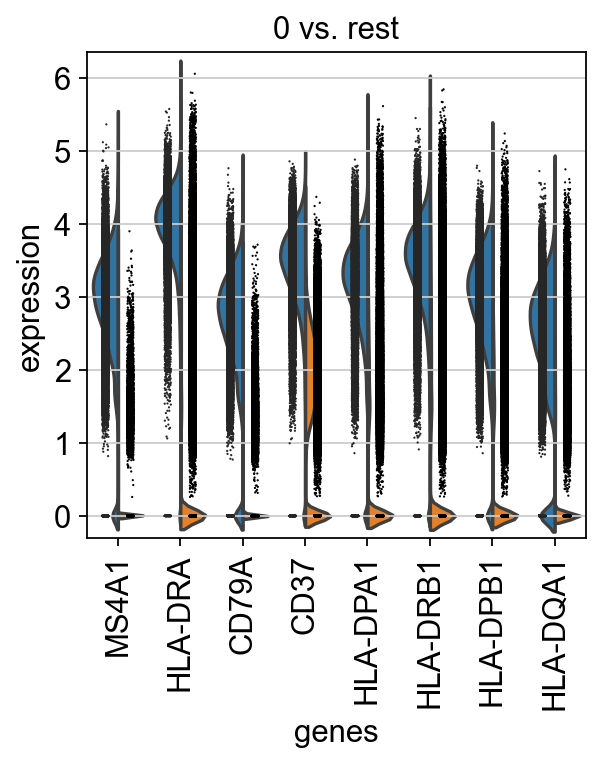

In [53]:
sc.pl.rank_genes_groups_violin(adata2, groups='0', n_genes=8)

In [54]:
sc.pl.violin(adata2, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')
#compare certain genes across groups

KeyError: "Could not find keys '['NKG7']' in columns of `adata.obs` or in adata.raw.var_names."

In [55]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata2.rename_categories('leiden', new_cluster_names)
#give cell types their "actual" name

C:\Users\louis.anderson\Maxiconda3\lib\site-packages\anndata\_core\anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


ValueError: new categories need to have the same number of items as the old categories!

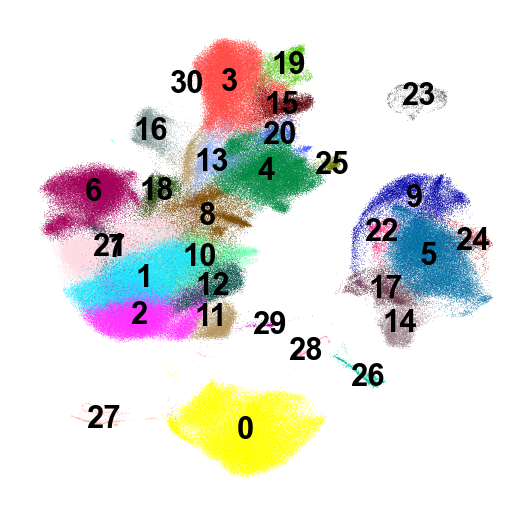

In [56]:
sc.pl.umap(adata2, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')
#map the marked cell types

In [57]:
#so we visualized the cell types
#now we visualize the marker genes
sc.pl.dotplot(adata2, marker_genes, groupby='leiden');


KeyError: "Could not find keys '['GNLY', 'NKG7', 'S100A8']' in columns of `adata.obs` or in adata.raw.var_names."

In [58]:
sc.pl.stacked_violin(adata2, marker_genes, groupby='leiden', rotation=90);
#compact violin plot for the marker genes

KeyError: "Could not find keys '['GNLY', 'NKG7', 'S100A8']' in columns of `adata.obs` or in adata.raw.var_names."

In [59]:
adata2
#now we want to see 
#what annotations AnnData accumulated
#during the process

AnnData object with n_obs × n_vars = 384606 × 970
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [60]:
adata2.write(results_file, compression='gzip')  
# `compression='gzip'` saves disk space
# but slows down writing and subsequent reading


In [61]:
adata2.raw.to_adata().write('./write/meyernikolic_withoutX.h5ad')
#here we remove the dense scaled and corrected data matrix
#in order to decrease the data size
#useful for visualization